<a href="https://colab.research.google.com/github/jihoonin/Face-recognition-/blob/main/06_FER2013_dataset_CNN_argument.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
FER-2013 데이터셋을 다운로드하고 전처리하여 학습, 검증, 테스트 세트로 분할

데이터셋 로드 성공:


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training



감정 분포:
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

DATA 분포:
Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

샘플 이미지 시각화:


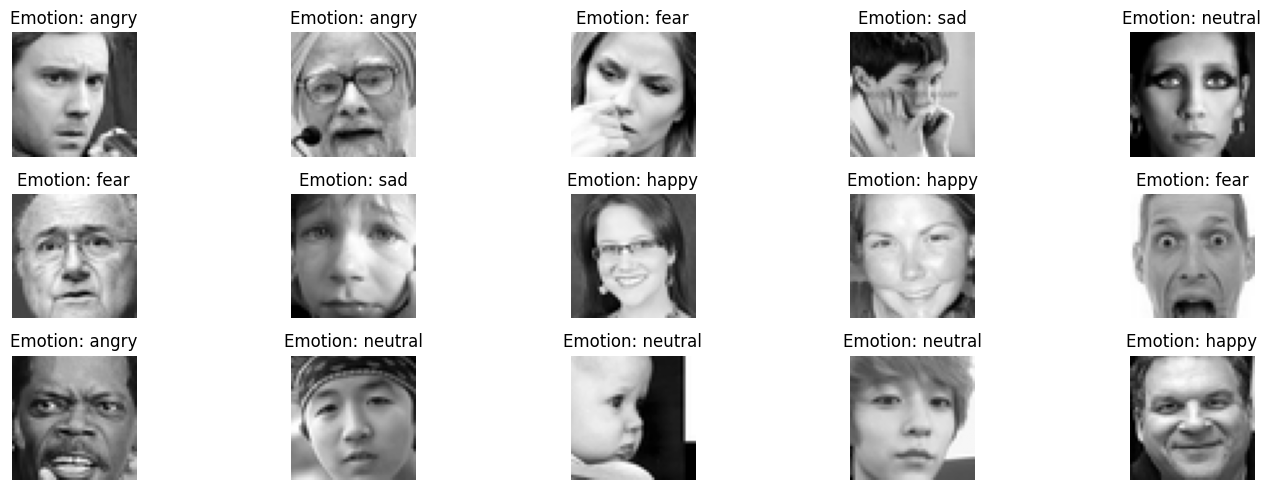

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#filepath = "/content/drive/MyDrive/data_colab/fer2013.csv"
filepath = "/content/drive/MyDrive/data/fer2013.csv"

emotion_labels = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

try:
    # Load the dataset
    df = pd.read_csv(filepath)
    print("데이터셋 로드 성공:")
    display(df.head(10))


    # Convert the pixel strings into numpy arrays
    df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split()).astype('float32'))

    # The 'emotion' column contains the labels
    # Let's see the distribution of emotions
    print("\n감정 분포:")
    print(df['emotion'].value_counts())

    print("\nDATA 분포:")
    print(df['Usage'].value_counts())

    # We can optionally visualize a few images
    print("\n샘플 이미지 시각화:")
    a, b = 3, 5 # Define a and b for subplot rows and columns
    fig, axes = plt.subplots(a, b, figsize=(15, 5))
    for i in range(a*b):
        pixels = df['pixels'].iloc[i].reshape(48, 48) # Assuming images are 48x48
        emotion_code = df['emotion'].iloc[i]
        emotion_name = emotion_labels.get(emotion_code, 'unknown') # Get emotion name using the mapping
        row_index = i // b # Calculate row index
        col_index = i % b # Calculate col index
        axes[row_index, col_index].imshow(pixels, cmap='gray') # Access subplot using row and column indices
        axes[row_index, col_index].set_title(f"Emotion: {emotion_name}") # Use emotion name in the title
        axes[row_index, col_index].axis('off')
    plt.tight_layout() # Adjust layout to prevent titles overlapping
    plt.show()

except FileNotFoundError:
    print(f"오류: '{filepath}' 파일을 찾을 수 없습니다. 파일을 업로드했는지 확인해주세요.")
except Exception as e:
    print(f"데이터 로드 또는 전처리 중 오류 발생: {e}")

## 데이터 분할

### Subtask:
데이터를 훈련, 검증 및 테스트 세트로 분할합니다.


In [ ]:
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']

print(f"훈련 세트 크기: {len(train_df)}")
print(f"검증 세트 크기: {len(val_df)}")
print(f"테스트 세트 크기: {len(test_df)}")

훈련 세트 크기: 28709
검증 세트 크기: 3589
테스트 세트 크기: 3589


## 데이터셋 및 데이터 로더 생성

### Subtask:
PyTorch `Dataset` 및 `DataLoader`를 생성하여 데이터를 효율적으로 로드하고 배치 처리


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class FER2013Dataset(Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['emotion'].values
        # Ensure pixels are numpy arrays of float32 and normalize
        self.images = np.stack(dataframe['pixels'].values).astype('float32') / 255.0
        # Reshape images to (N, 1, H, W) where N is number of samples, 1 is channels, H and W are height and width
        self.images = self.images.reshape(-1, 1, 48, 48)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Instantiate the datasets
train_dataset = FER2013Dataset(train_df)
val_dataset = FER2013Dataset(val_df)
test_dataset = FER2013Dataset(test_df)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 64 # Define batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nPyTorch Datasets and DataLoaders created successfully.")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Training set size: 28709
Validation set size: 3589
Test set size: 3589

PyTorch Datasets and DataLoaders created successfully.
Number of training batches: 449
Number of validation batches: 57
Number of test batches: 57


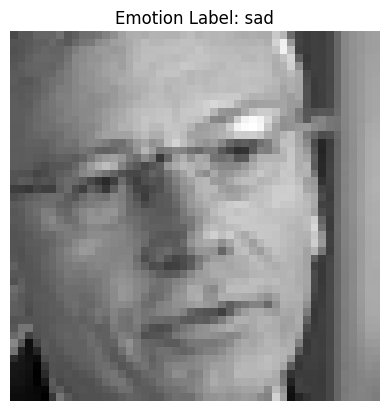

Image shape: torch.Size([1, 48, 48])
Label: 4
Emotion Name: sad


In [ ]:
# Get a batch of data from the training loader
images, labels = next(iter(train_loader))

# Take the first image and label from the batch
sample_image = images[0]
sample_label = labels[0]

# Convert the PyTorch tensor to a NumPy array for displaying
# Remove the channel dimension (1) and denormalize for display (multiply by 255)
sample_image_np = sample_image.squeeze(0).cpu().numpy() * 255.0

# Display the image
plt.imshow(sample_image_np, cmap='gray')
plt.title(f"Emotion Label: {emotion_labels.get(sample_label.item(), 'unknown')}")
plt.axis('off')
plt.show()

print(f"Image shape: {sample_image.shape}")
print(f"Label: {sample_label.item()}")
print(f"Emotion Name: {emotion_labels.get(sample_label.item(), 'unknown')}")

## Cnn 모델 정의


In [ ]:
import torch.nn as nn
import torch.nn.functional as F # Often useful for activation functions and pooling

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # First pooling layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # First dropout layer
        self.dropout1 = nn.Dropout(0.25) # Add dropout after pooling

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1, padding=1)
        # Second pooling layer
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second dropout layer
        self.dropout2 = nn.Dropout(0.25) # Add dropout after pooling

        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,stride=1, padding=1)
        # Third pooling layer
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Third dropout layer
        self.dropout3 = nn.Dropout(0.25) # Add dropout after pooling

        # Calculate the size of the flattened tensor after convolutional and pooling layers
        # Input image size is 48x48. After 3 pooling layers with kernel size 2 and stride 2,
        # the spatial dimensions will be (48 / 2 / 2 / 2) = 6x6
        self._to_linear = 128 * 6 * 6 # output channels of last conv * final height * final width

        # First fully connected layer
        self.fc1 = nn.Linear(self._to_linear, 512)
        # Fourth dropout layer (after first FC layer)
        self.dropout4 = nn.Dropout(0.5)

        # Second fully connected layer (output layer)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Apply first conv -> relu -> pool -> dropout
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        # Apply second conv -> relu -> pool -> dropout
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        # Apply third conv -> relu -> pool -> dropout
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, self._to_linear) # or x = torch.flatten(x, 1)

        # Apply first FC -> relu -> dropout
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)

        # Apply second FC (output layer)
        x = self.fc2(x)

        return x

print("EmotionCNN model class defined successfully.")

EmotionCNN model class defined successfully.


## 모델 훈련



In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

# Instantiate the model
model = EmotionCNN(num_classes=7)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Using device: {device}")

# Training and Validation Loop
num_epochs = 50 # Define the number of epochs
best_val_accuracy = 0.0
best_train_accuracy = 0.0 # Initialize best train accuracy
model_save_path = "best_emotion_cnn_model.pth" # Define path to save the best model

# Lists to store training and validation metrics
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = [] # List to store training accuracies

for epoch in range(num_epochs):
    # Training Phase
    model.train() # Set model to training mode
    running_train_loss = 0.0
    correct_train_predictions = 0 # Initialize correct train predictions
    total_train_predictions = 0 # Initialize total train predictions

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train_predictions += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()


    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_accuracy = correct_train_predictions / total_train_predictions # Calculate epoch train accuracy
    train_losses.append(epoch_train_loss) # Store training loss
    train_accuracies.append(epoch_train_accuracy) # Store training accuracy


    # Validation Phase
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val_predictions = 0 # Initialize correct validation predictions
    total_val_predictions = 0 # Initialize total validation predictions


    with torch.no_grad(): # Disable gradient calculation during validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val_predictions += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss) # Store validation loss
    val_accuracies.append(epoch_val_accuracy) # Store validation accuracy

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Accuracy: {epoch_train_accuracy:.4f}, " # Print training accuracy
          f"Validation Loss: {epoch_val_loss:.4f}, "
          f"Validation Accuracy: {epoch_val_accuracy:.4f}")

    # Save the best model
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved best model with validation accuracy: {best_val_accuracy:.4f}")

    # Update best train accuracy
    if epoch_train_accuracy > best_train_accuracy:
        best_train_accuracy = epoch_train_accuracy


print("\nTraining finished.")
print(f"Best validation accuracy achieved: {best_val_accuracy:.4f}")
print(f"Best train accuracy achieved: {best_train_accuracy:.4f}") # Print best train accuracy

Using device: cuda
Epoch [1/50], Train Loss: 1.7857, Train Accuracy: 0.2619, Validation Loss: 1.6933, Validation Accuracy: 0.3288
Saved best model with validation accuracy: 0.3288
Epoch [2/50], Train Loss: 1.6596, Train Accuracy: 0.3431, Validation Loss: 1.5514, Validation Accuracy: 0.4168
Saved best model with validation accuracy: 0.4168
Epoch [3/50], Train Loss: 1.5673, Train Accuracy: 0.3889, Validation Loss: 1.4715, Validation Accuracy: 0.4450
Saved best model with validation accuracy: 0.4450
Epoch [4/50], Train Loss: 1.5101, Train Accuracy: 0.4137, Validation Loss: 1.4001, Validation Accuracy: 0.4675
Saved best model with validation accuracy: 0.4675
Epoch [5/50], Train Loss: 1.4543, Train Accuracy: 0.4363, Validation Loss: 1.3483, Validation Accuracy: 0.4898
Saved best model with validation accuracy: 0.4898
Epoch [6/50], Train Loss: 1.4215, Train Accuracy: 0.4508, Validation Loss: 1.3447, Validation Accuracy: 0.4840
Epoch [7/50], Train Loss: 1.3972, Train Accuracy: 0.4623, Validat

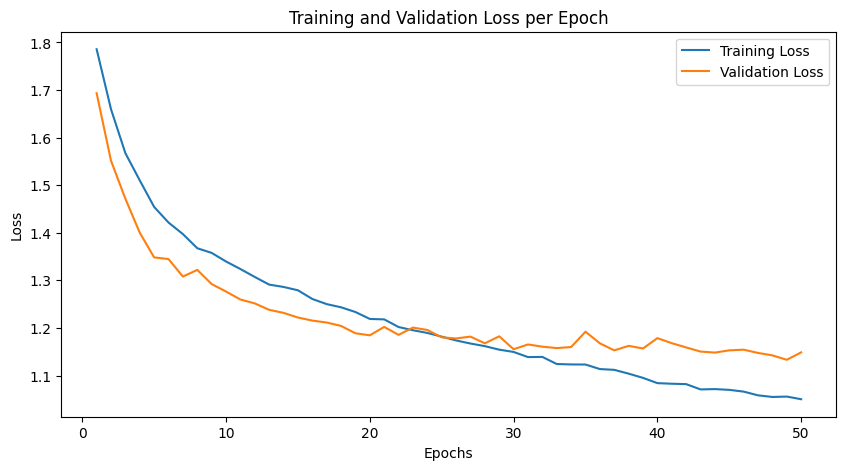

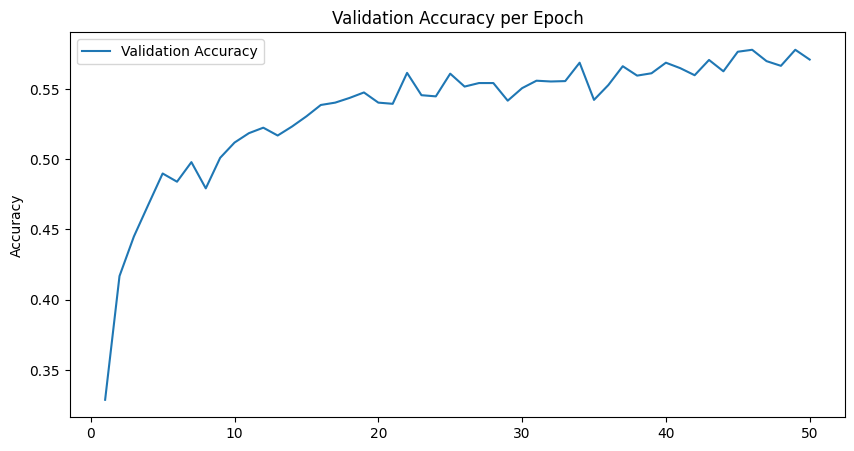

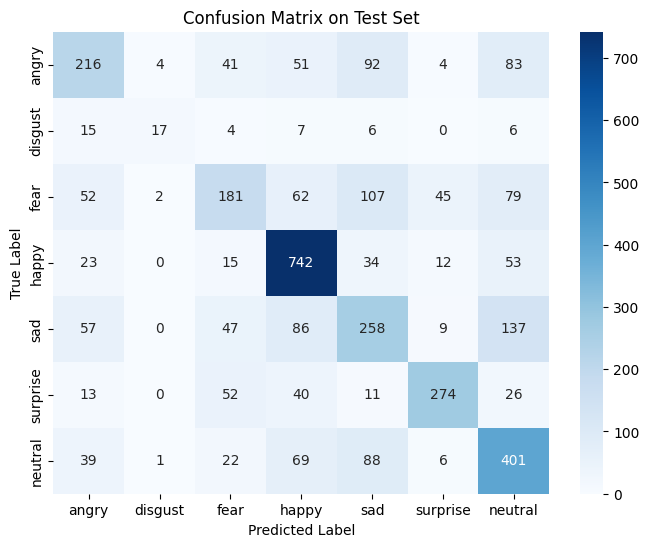


Classification Report on Test Set:
              precision    recall  f1-score   support

       angry       0.52      0.44      0.48       491
     disgust       0.71      0.31      0.43        55
        fear       0.50      0.34      0.41       528
       happy       0.70      0.84      0.77       879
         sad       0.43      0.43      0.43       594
    surprise       0.78      0.66      0.72       416
     neutral       0.51      0.64      0.57       626

    accuracy                           0.58      3589
   macro avg       0.59      0.52      0.54      3589
weighted avg       0.58      0.58      0.57      3589



In [ ]:
# Assuming you have stored training and validation loss/accuracy per epoch
# You would need to modify the training loop to store these values in lists

epochs = range(1, len(train_losses) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# To analyze test set predictions, you would need to collect predictions and true labels
# from the test_loader evaluation loop.

# Example of how to get predictions and true labels from the test set:
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Classification Report
print("\nClassification Report on Test Set:")
print(classification_report(all_labels, all_predictions, target_names=emotion_labels.values(), zero_division=0))

## 데이터 증강 변환 정의

### Subtask:
`torchvision.transforms`를 사용하여 이미지에 적용할 변환 (예: 랜덤 회전, 좌우 반전, 크기 조절 등)


In [ ]:
from torchvision import transforms

# Define transformations for the training set with data augmentation (removed Normalize)
train_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image for transforms
    transforms.RandomHorizontalFlip(), # Apply random horizontal flip
    transforms.RandomRotation(10), # Apply random rotation up to 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Apply random affine transformations
    transforms.ToTensor() # Convert PIL Image or numpy array to tensor
])

# Define transformations for the validation/test set (only ToTensor - removed Normalize)
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    transforms.ToTensor()
])

print("Data augmentation transformations defined successfully (Normalize removed).")

Data augmentation transformations defined successfully (Normalize removed).


In [ ]:
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.labels = dataframe['emotion'].values
        self.images = np.stack(dataframe['pixels'].values).astype('float32')
        self.transform = transform
        # Define normalization parameters
        self.normalize = transforms.Normalize(mean=[0.5], std=[0.5])


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Reshape to (H, W, 1) for ToPILImage
        image = self.images[idx].reshape(48, 48, 1)
        label = self.labels[idx]

        if self.transform:
            # Apply the defined transforms (now excluding Normalize)
            image = self.transform(image)
        else:
             # If no transform, convert to tensor and scale to [0, 1]
             image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0

        # Apply normalization consistently after getting the tensor
        image = self.normalize(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label

print("Modified FER2013Dataset class to include consistent normalization.")

Modified FER2013Dataset class to include consistent normalization.


In [ ]:
# Instantiate the datasets with the appropriate transformations
train_dataset_augmented = FER2013Dataset(train_df, transform=train_transforms)
val_dataset = FER2013Dataset(val_df, transform=val_test_transforms)
test_dataset = FER2013Dataset(test_df, transform=val_test_transforms)

# Create DataLoaders
batch_size = 64 # Define batch size
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set size (augmented): {len(train_dataset_augmented)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

print("\nPyTorch Datasets and DataLoaders created successfully with transformations (augmented).")
print(f"Number of training batches (augmented): {len(train_loader_augmented)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Training set size (augmented): 28709
Validation set size: 3589
Test set size: 3589

PyTorch Datasets and DataLoaders created successfully with transformations (augmented).
Number of training batches (augmented): 449
Number of validation batches: 57
Number of test batches: 57


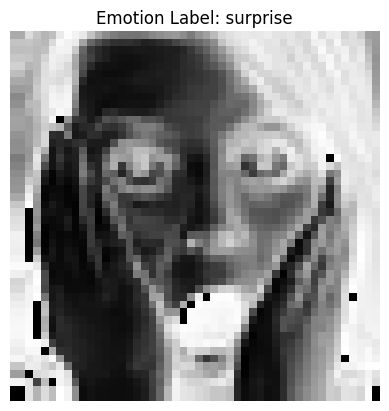

Image shape: torch.Size([1, 48, 48])
Label: 5
Emotion Name: surprise


In [ ]:
# Get a batch of data from the training loader
images, labels = next(iter(train_loader_augmented))

# Take the first image and label from the batch
sample_image = images[0]
sample_label = labels[0]

# Convert the PyTorch tensor to a NumPy array for displaying
# Remove the channel dimension (1) and denormalize for display (multiply by 255 and add mean)
# Need to reverse the normalization: image * std + mean
sample_image_np = sample_image.squeeze(0).cpu().numpy() * 0.5 + 0.5 # Denormalize for display
sample_image_np = sample_image_np * 255.0

# Display the image
plt.imshow(sample_image_np, cmap='gray')
plt.title(f"Emotion Label: {emotion_labels.get(sample_label.item(), 'unknown')}")
plt.axis('off')
plt.show()

print(f"Image shape: {sample_image.shape}")
print(f"Label: {sample_label.item()}")
print(f"Emotion Name: {emotion_labels.get(sample_label.item(), 'unknown')}")

## 모델 재훈련

### Subtask:
데이터 증강이 적용된 훈련 데이터를 사용하여 모델을 다시 훈련.


In [ ]:
# Instantiate the model
model = EmotionCNN(num_classes=7)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) # Using a slightly smaller learning rate with augmentation

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Using device: {device}")

# Training and Validation Loop
num_epochs = 50 # Increase epochs for training with augmentation
best_val_accuracy = 0.0
best_train_accuracy = 0.0 # Initialize best train accuracy
model_save_path = "best_emotion_cnn_model_augmented.pth" # Define path to save the best augmented model

# Lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = [] # List to store training accuracies
val_accuracies = []

for epoch in range(num_epochs):
    # Training Phase
    model.train() # Set model to training mode
    running_train_loss = 0.0
    correct_train_predictions = 0 # Counter for correct training predictions
    total_train_predictions = 0   # Counter for total training predictions

    for batch_idx, (images, labels) in enumerate(train_loader_augmented): # Use train_loader_augmented
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train_predictions += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()


    epoch_train_loss = running_train_loss / len(train_dataset_augmented) # Use train_dataset_augmented
    epoch_train_accuracy = correct_train_predictions / total_train_predictions # Calculate training accuracy
    train_losses.append(epoch_train_loss) # Store training loss
    train_accuracies.append(epoch_train_accuracy) # Store training accuracy

    # Update best train accuracy
    if epoch_train_accuracy > best_train_accuracy:
        best_train_accuracy = epoch_train_accuracy

    # Validation Phase
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val_predictions = 0 # Counter for correct validation predictions
    total_val_predictions = 0   # Counter for total validation predictions


    with torch.no_grad(): # Disable gradient calculation during validation
        for batch_idx, (images, labels) in enumerate(val_loader): # Use val_loader
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val_predictions += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataset) # Use val_dataset
    epoch_val_accuracy = correct_val_predictions / total_val_predictions # Calculate validation accuracy
    val_losses.append(epoch_val_loss) # Store validation loss
    val_accuracies.append(epoch_val_accuracy) # Store validation accuracy

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, " # Added training accuracy to print
          f"Validation Loss: {epoch_val_loss:.4f}, "
          f"Validation Accuracy: {epoch_val_accuracy:.4f}")

    # Save the best model
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved best model with validation accuracy: {best_val_accuracy:.4f}")


print("\nTraining finished.")
print(f"Best validation accuracy achieved: {best_val_accuracy:.4f}")
print(f"Best train accuracy achieved: {best_train_accuracy:.4f}") # Print best train accuracy

Using device: cuda
Epoch [1/50], Train Loss: 1.7479, Train Accuracy: 0.2810, Validation Loss: 1.6371, Validation Accuracy: 0.3569
Saved best model with validation accuracy: 0.3569
Epoch [2/50], Train Loss: 1.6246, Train Accuracy: 0.3607, Validation Loss: 1.4537, Validation Accuracy: 0.4458
Saved best model with validation accuracy: 0.4458
Epoch [3/50], Train Loss: 1.5191, Train Accuracy: 0.4086, Validation Loss: 1.3680, Validation Accuracy: 0.4748
Saved best model with validation accuracy: 0.4748
Epoch [4/50], Train Loss: 1.4541, Train Accuracy: 0.4338, Validation Loss: 1.3131, Validation Accuracy: 0.4962
Saved best model with validation accuracy: 0.4962
Epoch [5/50], Train Loss: 1.4152, Train Accuracy: 0.4556, Validation Loss: 1.2790, Validation Accuracy: 0.5063
Saved best model with validation accuracy: 0.5063
Epoch [6/50], Train Loss: 1.3797, Train Accuracy: 0.4719, Validation Loss: 1.2414, Validation Accuracy: 0.5163
Saved best model with validation accuracy: 0.5163
Epoch [7/50], T

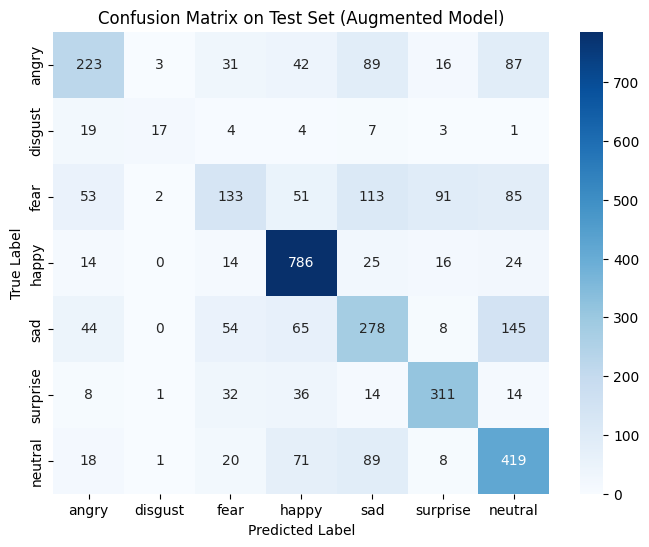


Classification Report on Test Set (Augmented Model):
              precision    recall  f1-score   support

       angry       0.59      0.45      0.51       491
     disgust       0.71      0.31      0.43        55
        fear       0.46      0.25      0.33       528
       happy       0.75      0.89      0.81       879
         sad       0.45      0.47      0.46       594
    surprise       0.69      0.75      0.72       416
     neutral       0.54      0.67      0.60       626

    accuracy                           0.60      3589
   macro avg       0.60      0.54      0.55      3589
weighted avg       0.59      0.60      0.59      3589



In [ ]:
# Load the best model
model = EmotionCNN(num_classes=7)
model.load_state_dict(torch.load("best_emotion_cnn_model_augmented.pth"))
model.to(device)

# Evaluate on the test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader: # Use test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set (Augmented Model)')
plt.show()

# Classification Report
print("\nClassification Report on Test Set (Augmented Model):")
print(classification_report(all_labels, all_predictions, target_names=emotion_labels.values(), zero_division=0))